# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 451 kB 19.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 241 kB 28.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 65 kB 4.5 MB/s  eta 0:00:01
     |████████████████████████████████| 146 kB 57.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 50 kB 6.9 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [11]:
client = MongoClient(mongod_connect)
db = client.gp24 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [12]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [13]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [14]:
count = 100 #number of returned tweets, default and max is 100
geocode = "38.4392897,-77.9412224,200mi"  
q = "covid19"                       

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [15]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Wed Dec 01 22:38:15 +0000 2021'
'Wed Dec 01 22:38:06 +0000 2021'
'Wed Dec 01 22:36:19 +0000 2021'
'Wed Dec 01 22:36:00 +0000 2021'
'Wed Dec 01 22:35:13 +0000 2021'
'Wed Dec 01 22:34:00 +0000 2021'
'Wed Dec 01 22:32:52 +0000 2021'
'Wed Dec 01 22:32:52 +0000 2021'
'Wed Dec 01 22:31:27 +0000 2021'
'Wed Dec 01 22:30:10 +0000 2021'
'Wed Dec 01 22:30:07 +0000 2021'
'Wed Dec 01 22:28:11 +0000 2021'
'Wed Dec 01 22:27:42 +0000 2021'
'Wed Dec 01 22:26:26 +0000 2021'
'Wed Dec 01 22:26:17 +0000 2021'
'Wed Dec 01 22:23:19 +0000 2021'
'Wed Dec 01 22:20:31 +0000 2021'
'Wed Dec 01 22:20:18 +0000 2021'
'Wed Dec 01 22:20:12 +0000 2021'
'Wed Dec 01 22:15:03 +0000 2021'
'Wed Dec 01 22:15:03 +0000 2021'
'Wed Dec 01 22:12:47 +0000 2021'
'Wed Dec 01 22:11:23 +0000 2021'
'Wed Dec 01 22:09:34 +0000 2021'
'Wed Dec 01 22:09:02 +0000 2021'
'Wed Dec 01 22:03:19 +0000 2021'
'Wed Dec 01 22:01:35 +0000 2021'
'Wed Dec 01 22:01:13 +0000 2021'
'Wed Dec 01 22:01:04 +0000 2021'
'Wed Dec 01 22:00:00 +0000 2021'
'Wed Dec 0

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [18]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Wed Dec 01 17:41:15 +0000 2021'
'Wed Dec 01 17:40:25 +0000 2021'
'Wed Dec 01 17:39:01 +0000 2021'
'Wed Dec 01 17:38:04 +0000 2021'
'Wed Dec 01 17:37:21 +0000 2021'
'Wed Dec 01 17:36:08 +0000 2021'
'Wed Dec 01 17:35:51 +0000 2021'
'Wed Dec 01 17:34:46 +0000 2021'
'Wed Dec 01 17:32:40 +0000 2021'
'Wed Dec 01 17:32:22 +0000 2021'
'Wed Dec 01 17:27:15 +0000 2021'
'Wed Dec 01 17:26:00 +0000 2021'
'Wed Dec 01 17:25:37 +0000 2021'
'Wed Dec 01 17:25:05 +0000 2021'
'Wed Dec 01 17:24:14 +0000 2021'
'Wed Dec 01 17:23:47 +0000 2021'
'Wed Dec 01 17:23:27 +0000 2021'
'Wed Dec 01 17:22:53 +0000 2021'
'Wed Dec 01 17:21:34 +0000 2021'
'Wed Dec 01 17:21:03 +0000 2021'
'Wed Dec 01 17:20:07 +0000 2021'
'Wed Dec 01 17:20:05 +0000 2021'
'Wed Dec 01 17:18:02 +0000 2021'
'Wed Dec 01 17:17:43 +0000 2021'
'Wed Dec 01 17:17:11 +0000 2021'
'Wed Dec 01 17:15:34 +0000 2021'
'Wed Dec 01 17:15:11 +0000 2021'
'Wed Dec 01 17:15:09 +0000 2021'
'Wed Dec 01 17:15:06 +0000 2021'
'Wed Dec 01 17:15:06 +0000 2021'
'Wed Dec 0

'Wed Dec 01 14:32:40 +0000 2021'
'Wed Dec 01 14:32:08 +0000 2021'
'Wed Dec 01 14:32:04 +0000 2021'
'Wed Dec 01 14:31:50 +0000 2021'
'Wed Dec 01 14:31:39 +0000 2021'
'Wed Dec 01 14:31:36 +0000 2021'
'Wed Dec 01 14:31:19 +0000 2021'
'Wed Dec 01 14:30:28 +0000 2021'
'Wed Dec 01 14:29:54 +0000 2021'
'Wed Dec 01 14:28:42 +0000 2021'
'Wed Dec 01 14:28:34 +0000 2021'
'Wed Dec 01 14:25:01 +0000 2021'
'Wed Dec 01 14:24:35 +0000 2021'
'Wed Dec 01 14:24:01 +0000 2021'
'Wed Dec 01 14:21:00 +0000 2021'
'Wed Dec 01 14:20:14 +0000 2021'
'Wed Dec 01 14:18:10 +0000 2021'
'Wed Dec 01 14:15:08 +0000 2021'
'Wed Dec 01 14:15:05 +0000 2021'
'Wed Dec 01 14:15:05 +0000 2021'
'Wed Dec 01 14:10:32 +0000 2021'
'Wed Dec 01 14:10:28 +0000 2021'
'Wed Dec 01 14:10:02 +0000 2021'
'Wed Dec 01 14:09:53 +0000 2021'
'Wed Dec 01 14:09:52 +0000 2021'
'Wed Dec 01 14:07:22 +0000 2021'
'Wed Dec 01 14:07:18 +0000 2021'
'Wed Dec 01 14:06:57 +0000 2021'
'Wed Dec 01 14:05:29 +0000 2021'
'Wed Dec 01 14:03:36 +0000 2021'
'Wed Dec 0

'Wed Dec 01 03:11:49 +0000 2021'
'Wed Dec 01 03:10:43 +0000 2021'
'Wed Dec 01 03:09:56 +0000 2021'
'Wed Dec 01 03:09:29 +0000 2021'
'Wed Dec 01 03:01:47 +0000 2021'
'Wed Dec 01 03:00:32 +0000 2021'
'Wed Dec 01 03:00:18 +0000 2021'
'Wed Dec 01 02:58:09 +0000 2021'
'Wed Dec 01 02:56:37 +0000 2021'
'Wed Dec 01 02:55:39 +0000 2021'
'Wed Dec 01 02:54:58 +0000 2021'
'Wed Dec 01 02:53:11 +0000 2021'
'Wed Dec 01 02:46:07 +0000 2021'
'Wed Dec 01 02:44:55 +0000 2021'
'Wed Dec 01 02:42:23 +0000 2021'
'Wed Dec 01 02:39:24 +0000 2021'
'Wed Dec 01 02:33:47 +0000 2021'
'Wed Dec 01 02:32:55 +0000 2021'
'Wed Dec 01 02:32:39 +0000 2021'
'Wed Dec 01 02:30:08 +0000 2021'
'Wed Dec 01 02:28:42 +0000 2021'
'Wed Dec 01 02:28:38 +0000 2021'
'Wed Dec 01 02:26:43 +0000 2021'
'Wed Dec 01 02:24:42 +0000 2021'
'Wed Dec 01 02:23:02 +0000 2021'
'Wed Dec 01 02:14:30 +0000 2021'
'Wed Dec 01 02:13:01 +0000 2021'
'Wed Dec 01 02:09:38 +0000 2021'
'Wed Dec 01 02:08:29 +0000 2021'
'Wed Dec 01 02:07:45 +0000 2021'
'Wed Dec 0

'Tue Nov 30 20:47:31 +0000 2021'
'Tue Nov 30 20:47:13 +0000 2021'
'Tue Nov 30 20:45:04 +0000 2021'
'Tue Nov 30 20:45:00 +0000 2021'
'Tue Nov 30 20:44:29 +0000 2021'
'Tue Nov 30 20:41:01 +0000 2021'
'Tue Nov 30 20:39:17 +0000 2021'
'Tue Nov 30 20:37:54 +0000 2021'
'Tue Nov 30 20:37:19 +0000 2021'
'Tue Nov 30 20:36:23 +0000 2021'
'Tue Nov 30 20:36:16 +0000 2021'
'Tue Nov 30 20:35:59 +0000 2021'
'Tue Nov 30 20:35:40 +0000 2021'
'Tue Nov 30 20:35:20 +0000 2021'
'Tue Nov 30 20:34:53 +0000 2021'
'Tue Nov 30 20:34:22 +0000 2021'
'Tue Nov 30 20:33:10 +0000 2021'
'Tue Nov 30 20:33:00 +0000 2021'
'Tue Nov 30 20:32:17 +0000 2021'
'Tue Nov 30 20:30:00 +0000 2021'
'Tue Nov 30 20:28:52 +0000 2021'
'Tue Nov 30 20:28:29 +0000 2021'
'Tue Nov 30 20:28:28 +0000 2021'
'Tue Nov 30 20:28:14 +0000 2021'
'Tue Nov 30 20:27:22 +0000 2021'
'Tue Nov 30 20:27:00 +0000 2021'
'Tue Nov 30 20:26:30 +0000 2021'
'Tue Nov 30 20:24:02 +0000 2021'
'Tue Nov 30 20:21:29 +0000 2021'
'Tue Nov 30 20:17:58 +0000 2021'
'Tue Nov 3

'Tue Nov 30 16:30:00 +0000 2021'
'Tue Nov 30 16:30:00 +0000 2021'
'Tue Nov 30 16:30:00 +0000 2021'
'Tue Nov 30 16:29:46 +0000 2021'
'Tue Nov 30 16:28:28 +0000 2021'
'Tue Nov 30 16:28:08 +0000 2021'
'Tue Nov 30 16:28:04 +0000 2021'
'Tue Nov 30 16:27:16 +0000 2021'
'Tue Nov 30 16:27:12 +0000 2021'
'Tue Nov 30 16:25:55 +0000 2021'
'Tue Nov 30 16:24:14 +0000 2021'
'Tue Nov 30 16:22:50 +0000 2021'
'Tue Nov 30 16:22:30 +0000 2021'
'Tue Nov 30 16:22:28 +0000 2021'
'Tue Nov 30 16:21:49 +0000 2021'
'Tue Nov 30 16:21:12 +0000 2021'
'Tue Nov 30 16:20:58 +0000 2021'
'Tue Nov 30 16:20:31 +0000 2021'
'Tue Nov 30 16:19:24 +0000 2021'
'Tue Nov 30 16:17:52 +0000 2021'
'Tue Nov 30 16:17:04 +0000 2021'
'Tue Nov 30 16:16:28 +0000 2021'
'Tue Nov 30 16:15:49 +0000 2021'
'Tue Nov 30 16:15:48 +0000 2021'
'Tue Nov 30 16:15:00 +0000 2021'
'Tue Nov 30 16:14:05 +0000 2021'
'Tue Nov 30 16:13:31 +0000 2021'
'Tue Nov 30 16:12:16 +0000 2021'
'Tue Nov 30 16:11:12 +0000 2021'
'Tue Nov 30 16:10:02 +0000 2021'
'Tue Nov 3

'Tue Nov 30 13:08:31 +0000 2021'
'Tue Nov 30 13:07:55 +0000 2021'
'Tue Nov 30 13:07:36 +0000 2021'
'Tue Nov 30 13:07:00 +0000 2021'
'Tue Nov 30 13:06:59 +0000 2021'
'Tue Nov 30 13:05:18 +0000 2021'
'Tue Nov 30 13:04:41 +0000 2021'
'Tue Nov 30 13:03:24 +0000 2021'
'Tue Nov 30 13:02:31 +0000 2021'
'Tue Nov 30 13:02:16 +0000 2021'
'Tue Nov 30 13:01:32 +0000 2021'
'Tue Nov 30 13:01:26 +0000 2021'
'Tue Nov 30 12:59:38 +0000 2021'
'Tue Nov 30 12:57:30 +0000 2021'
'Tue Nov 30 12:56:34 +0000 2021'
'Tue Nov 30 12:55:39 +0000 2021'
'Tue Nov 30 12:53:58 +0000 2021'
'Tue Nov 30 12:53:58 +0000 2021'
'Tue Nov 30 12:47:15 +0000 2021'
'Tue Nov 30 12:47:01 +0000 2021'
'Tue Nov 30 12:45:51 +0000 2021'
'Tue Nov 30 12:43:29 +0000 2021'
'Tue Nov 30 12:42:05 +0000 2021'
'Tue Nov 30 12:40:00 +0000 2021'
'Tue Nov 30 12:38:21 +0000 2021'
'Tue Nov 30 12:35:18 +0000 2021'
'Tue Nov 30 12:34:53 +0000 2021'
'Tue Nov 30 12:33:59 +0000 2021'
'Tue Nov 30 12:33:44 +0000 2021'
'Tue Nov 30 12:30:13 +0000 2021'
'Tue Nov 3

'Tue Nov 30 00:01:24 +0000 2021'
'Tue Nov 30 00:00:24 +0000 2021'
'Tue Nov 30 00:00:01 +0000 2021'
'Mon Nov 29 23:57:58 +0000 2021'
'Mon Nov 29 23:56:34 +0000 2021'
'Mon Nov 29 23:55:28 +0000 2021'
'Mon Nov 29 23:54:59 +0000 2021'
'Mon Nov 29 23:49:40 +0000 2021'
'Mon Nov 29 23:49:10 +0000 2021'
'Mon Nov 29 23:48:41 +0000 2021'
'Mon Nov 29 23:45:37 +0000 2021'
'Mon Nov 29 23:45:01 +0000 2021'
'Mon Nov 29 23:45:01 +0000 2021'
'Mon Nov 29 23:41:50 +0000 2021'
'Mon Nov 29 23:40:20 +0000 2021'
'Mon Nov 29 23:39:01 +0000 2021'
'Mon Nov 29 23:34:01 +0000 2021'
'Mon Nov 29 23:30:43 +0000 2021'
'Mon Nov 29 23:30:04 +0000 2021'
'Mon Nov 29 23:28:19 +0000 2021'
'Mon Nov 29 23:27:02 +0000 2021'
'Mon Nov 29 23:26:52 +0000 2021'
'Mon Nov 29 23:21:20 +0000 2021'
'Mon Nov 29 23:19:44 +0000 2021'
'Mon Nov 29 23:14:56 +0000 2021'
'Mon Nov 29 23:11:54 +0000 2021'
'Mon Nov 29 23:11:29 +0000 2021'
'Mon Nov 29 23:11:22 +0000 2021'
'Mon Nov 29 23:11:13 +0000 2021'
'Mon Nov 29 23:09:59 +0000 2021'
'Mon Nov 2

'Mon Nov 29 18:30:46 +0000 2021'
'Mon Nov 29 18:30:06 +0000 2021'
'Mon Nov 29 18:30:06 +0000 2021'
'Mon Nov 29 18:30:01 +0000 2021'
'Mon Nov 29 18:27:57 +0000 2021'
'Mon Nov 29 18:26:12 +0000 2021'
'Mon Nov 29 18:26:09 +0000 2021'
'Mon Nov 29 18:26:08 +0000 2021'
'Mon Nov 29 18:25:29 +0000 2021'
'Mon Nov 29 18:25:16 +0000 2021'
'Mon Nov 29 18:24:47 +0000 2021'
'Mon Nov 29 18:24:28 +0000 2021'
'Mon Nov 29 18:24:09 +0000 2021'
'Mon Nov 29 18:23:47 +0000 2021'
'Mon Nov 29 18:23:19 +0000 2021'
'Mon Nov 29 18:22:57 +0000 2021'
'Mon Nov 29 18:22:50 +0000 2021'
'Mon Nov 29 18:22:45 +0000 2021'
'Mon Nov 29 18:21:23 +0000 2021'
'Mon Nov 29 18:20:42 +0000 2021'
'Mon Nov 29 18:20:03 +0000 2021'
'Mon Nov 29 18:18:03 +0000 2021'
'Mon Nov 29 18:17:05 +0000 2021'
'Mon Nov 29 18:17:00 +0000 2021'
'Mon Nov 29 18:16:01 +0000 2021'
'Mon Nov 29 18:15:28 +0000 2021'
'Mon Nov 29 18:14:07 +0000 2021'
'Mon Nov 29 18:13:51 +0000 2021'
'Mon Nov 29 18:13:44 +0000 2021'
'Mon Nov 29 18:10:17 +0000 2021'
'Mon Nov 2

'Mon Nov 29 15:18:38 +0000 2021'
'Mon Nov 29 15:17:38 +0000 2021'
'Mon Nov 29 15:15:19 +0000 2021'
'Mon Nov 29 15:15:11 +0000 2021'
'Mon Nov 29 15:15:10 +0000 2021'
'Mon Nov 29 15:15:10 +0000 2021'
'Mon Nov 29 15:14:23 +0000 2021'
'Mon Nov 29 15:12:56 +0000 2021'
'Mon Nov 29 15:11:31 +0000 2021'
'Mon Nov 29 15:07:02 +0000 2021'
'Mon Nov 29 15:05:12 +0000 2021'
'Mon Nov 29 15:05:02 +0000 2021'
'Mon Nov 29 15:04:03 +0000 2021'
'Mon Nov 29 15:03:27 +0000 2021'
'Mon Nov 29 15:03:08 +0000 2021'
'Mon Nov 29 15:03:07 +0000 2021'
'Mon Nov 29 15:03:00 +0000 2021'
'Mon Nov 29 15:00:02 +0000 2021'
'Mon Nov 29 15:00:01 +0000 2021'
'Mon Nov 29 14:59:34 +0000 2021'
'Mon Nov 29 14:59:01 +0000 2021'
'Mon Nov 29 14:58:48 +0000 2021'
'Mon Nov 29 14:57:11 +0000 2021'
'Mon Nov 29 14:57:07 +0000 2021'
'Mon Nov 29 14:55:10 +0000 2021'
'Mon Nov 29 14:51:33 +0000 2021'
'Mon Nov 29 14:51:30 +0000 2021'
'Mon Nov 29 14:49:00 +0000 2021'
'Mon Nov 29 14:44:26 +0000 2021'
'Mon Nov 29 14:43:36 +0000 2021'
'Mon Nov 2

'Mon Nov 29 01:41:39 +0000 2021'
'Mon Nov 29 01:40:33 +0000 2021'
'Mon Nov 29 01:34:18 +0000 2021'
'Mon Nov 29 01:33:36 +0000 2021'
'Mon Nov 29 01:31:57 +0000 2021'
'Mon Nov 29 01:26:49 +0000 2021'
'Mon Nov 29 01:24:49 +0000 2021'
'Mon Nov 29 01:23:47 +0000 2021'
'Mon Nov 29 01:21:36 +0000 2021'
'Mon Nov 29 01:21:10 +0000 2021'
'Mon Nov 29 01:16:15 +0000 2021'
'Mon Nov 29 01:15:15 +0000 2021'
'Mon Nov 29 01:13:31 +0000 2021'
'Mon Nov 29 01:10:35 +0000 2021'
'Mon Nov 29 01:06:37 +0000 2021'
'Mon Nov 29 01:04:33 +0000 2021'
'Mon Nov 29 01:04:00 +0000 2021'
'Mon Nov 29 01:01:49 +0000 2021'
'Mon Nov 29 00:58:25 +0000 2021'
'Mon Nov 29 00:57:24 +0000 2021'
'Mon Nov 29 00:57:16 +0000 2021'
'Mon Nov 29 00:54:37 +0000 2021'
'Mon Nov 29 00:51:14 +0000 2021'
'Mon Nov 29 00:49:08 +0000 2021'
'Mon Nov 29 00:49:04 +0000 2021'
'Mon Nov 29 00:47:04 +0000 2021'
'Mon Nov 29 00:45:04 +0000 2021'
'Mon Nov 29 00:39:47 +0000 2021'
'Mon Nov 29 00:38:26 +0000 2021'
'Mon Nov 29 00:37:39 +0000 2021'
'Mon Nov 2

'Sun Nov 28 17:00:35 +0000 2021'
'Sun Nov 28 17:00:01 +0000 2021'
'Sun Nov 28 17:00:00 +0000 2021'
'Sun Nov 28 16:58:10 +0000 2021'
'Sun Nov 28 16:54:19 +0000 2021'
'Sun Nov 28 16:42:15 +0000 2021'
'Sun Nov 28 16:41:18 +0000 2021'
'Sun Nov 28 16:35:42 +0000 2021'
'Sun Nov 28 16:34:01 +0000 2021'
'Sun Nov 28 16:33:06 +0000 2021'
'Sun Nov 28 16:30:07 +0000 2021'
'Sun Nov 28 16:29:33 +0000 2021'
'Sun Nov 28 16:25:10 +0000 2021'
'Sun Nov 28 16:24:51 +0000 2021'
'Sun Nov 28 16:21:36 +0000 2021'
'Sun Nov 28 16:21:29 +0000 2021'
'Sun Nov 28 16:21:28 +0000 2021'
'Sun Nov 28 16:21:26 +0000 2021'
'Sun Nov 28 16:21:25 +0000 2021'
'Sun Nov 28 16:21:24 +0000 2021'
'Sun Nov 28 16:16:59 +0000 2021'
'Sun Nov 28 16:15:22 +0000 2021'
'Sun Nov 28 16:15:05 +0000 2021'
'Sun Nov 28 16:11:35 +0000 2021'
'Sun Nov 28 16:11:23 +0000 2021'
'Sun Nov 28 16:08:55 +0000 2021'
'Sun Nov 28 16:06:28 +0000 2021'
'Sun Nov 28 16:03:05 +0000 2021'
'Sun Nov 28 16:02:21 +0000 2021'
'Sun Nov 28 15:59:48 +0000 2021'
'Sun Nov 2

'Sun Nov 28 00:24:49 +0000 2021'
'Sun Nov 28 00:19:04 +0000 2021'
'Sun Nov 28 00:15:02 +0000 2021'
'Sun Nov 28 00:14:29 +0000 2021'
'Sun Nov 28 00:12:28 +0000 2021'
'Sun Nov 28 00:05:14 +0000 2021'
'Sun Nov 28 00:01:07 +0000 2021'
'Sun Nov 28 00:00:40 +0000 2021'
'Sat Nov 27 23:56:14 +0000 2021'
'Sat Nov 27 23:55:00 +0000 2021'
'Sat Nov 27 23:52:42 +0000 2021'
'Sat Nov 27 23:49:01 +0000 2021'
'Sat Nov 27 23:47:40 +0000 2021'
'Sat Nov 27 23:45:05 +0000 2021'
'Sat Nov 27 23:43:33 +0000 2021'
'Sat Nov 27 23:42:33 +0000 2021'
'Sat Nov 27 23:41:15 +0000 2021'
'Sat Nov 27 23:41:04 +0000 2021'
'Sat Nov 27 23:39:42 +0000 2021'
'Sat Nov 27 23:25:50 +0000 2021'
'Sat Nov 27 23:25:14 +0000 2021'
'Sat Nov 27 23:22:07 +0000 2021'
'Sat Nov 27 23:18:13 +0000 2021'
'Sat Nov 27 23:13:40 +0000 2021'
'Sat Nov 27 23:12:12 +0000 2021'
'Sat Nov 27 23:11:41 +0000 2021'
'Sat Nov 27 23:11:32 +0000 2021'
'Sat Nov 27 23:10:02 +0000 2021'
'Sat Nov 27 23:06:02 +0000 2021'
'Sat Nov 27 23:03:09 +0000 2021'
'Sat Nov 2

'Sat Nov 27 16:30:58 +0000 2021'
'Sat Nov 27 16:30:20 +0000 2021'
'Sat Nov 27 16:29:10 +0000 2021'
'Sat Nov 27 16:27:44 +0000 2021'
'Sat Nov 27 16:27:07 +0000 2021'
'Sat Nov 27 16:22:58 +0000 2021'
'Sat Nov 27 16:17:20 +0000 2021'
'Sat Nov 27 16:16:07 +0000 2021'
'Sat Nov 27 16:15:06 +0000 2021'
'Sat Nov 27 16:15:02 +0000 2021'
'Sat Nov 27 16:13:02 +0000 2021'
'Sat Nov 27 16:12:04 +0000 2021'
'Sat Nov 27 16:11:11 +0000 2021'
'Sat Nov 27 16:11:00 +0000 2021'
'Sat Nov 27 16:10:20 +0000 2021'
'Sat Nov 27 16:09:03 +0000 2021'
'Sat Nov 27 16:08:29 +0000 2021'
'Sat Nov 27 16:00:58 +0000 2021'
'Sat Nov 27 16:00:35 +0000 2021'
'Sat Nov 27 16:00:21 +0000 2021'
'Sat Nov 27 16:00:21 +0000 2021'
'Sat Nov 27 16:00:16 +0000 2021'
'Sat Nov 27 16:00:05 +0000 2021'
'Sat Nov 27 16:00:00 +0000 2021'
'Sat Nov 27 15:59:46 +0000 2021'
'Sat Nov 27 15:59:43 +0000 2021'
'Sat Nov 27 15:58:49 +0000 2021'
'Sat Nov 27 15:53:51 +0000 2021'
'Sat Nov 27 15:51:19 +0000 2021'
'Sat Nov 27 15:49:56 +0000 2021'
'Sat Nov 2

'Sat Nov 27 02:18:55 +0000 2021'
'Sat Nov 27 02:16:39 +0000 2021'
'Sat Nov 27 02:13:03 +0000 2021'
'Sat Nov 27 02:13:01 +0000 2021'
'Sat Nov 27 02:11:09 +0000 2021'
'Sat Nov 27 02:04:19 +0000 2021'
'Sat Nov 27 02:02:12 +0000 2021'
'Sat Nov 27 02:01:57 +0000 2021'
'Sat Nov 27 01:59:19 +0000 2021'
'Sat Nov 27 01:54:29 +0000 2021'
'Sat Nov 27 01:53:03 +0000 2021'
'Sat Nov 27 01:52:33 +0000 2021'
'Sat Nov 27 01:46:21 +0000 2021'
'Sat Nov 27 01:41:49 +0000 2021'
'Sat Nov 27 01:40:04 +0000 2021'
'Sat Nov 27 01:39:51 +0000 2021'
'Sat Nov 27 01:39:04 +0000 2021'
'Sat Nov 27 01:37:37 +0000 2021'
'Sat Nov 27 01:37:15 +0000 2021'
'Sat Nov 27 01:36:54 +0000 2021'
'Sat Nov 27 01:36:21 +0000 2021'
'Sat Nov 27 01:36:16 +0000 2021'
'Sat Nov 27 01:36:11 +0000 2021'
'Sat Nov 27 01:34:38 +0000 2021'
'Sat Nov 27 01:32:17 +0000 2021'
'Sat Nov 27 01:31:50 +0000 2021'
'Sat Nov 27 01:31:33 +0000 2021'
'Sat Nov 27 01:28:08 +0000 2021'
'Sat Nov 27 01:26:49 +0000 2021'
'Sat Nov 27 01:25:37 +0000 2021'
'Sat Nov 2

'Fri Nov 26 19:16:49 +0000 2021'
'Fri Nov 26 19:16:00 +0000 2021'
'Fri Nov 26 19:14:42 +0000 2021'
'Fri Nov 26 19:12:17 +0000 2021'
'Fri Nov 26 19:11:35 +0000 2021'
'Fri Nov 26 19:11:12 +0000 2021'
'Fri Nov 26 19:10:45 +0000 2021'
'Fri Nov 26 19:10:32 +0000 2021'
'Fri Nov 26 19:10:25 +0000 2021'
'Fri Nov 26 19:09:28 +0000 2021'
'Fri Nov 26 19:09:21 +0000 2021'
'Fri Nov 26 19:09:04 +0000 2021'
'Fri Nov 26 19:08:58 +0000 2021'
'Fri Nov 26 19:08:09 +0000 2021'
'Fri Nov 26 19:07:54 +0000 2021'
'Fri Nov 26 19:07:48 +0000 2021'
'Fri Nov 26 19:07:24 +0000 2021'
'Fri Nov 26 19:04:01 +0000 2021'
'Fri Nov 26 19:03:31 +0000 2021'
'Fri Nov 26 19:02:30 +0000 2021'
'Fri Nov 26 19:02:14 +0000 2021'
'Fri Nov 26 19:01:35 +0000 2021'
'Fri Nov 26 19:00:28 +0000 2021'
'Fri Nov 26 18:57:53 +0000 2021'
'Fri Nov 26 18:57:41 +0000 2021'
'Fri Nov 26 18:57:39 +0000 2021'
'Fri Nov 26 18:56:44 +0000 2021'
'Fri Nov 26 18:55:24 +0000 2021'
'Fri Nov 26 18:55:03 +0000 2021'
'Fri Nov 26 18:53:57 +0000 2021'
'Fri Nov 2

'Fri Nov 26 14:00:27 +0000 2021'
'Fri Nov 26 14:00:18 +0000 2021'
'Fri Nov 26 13:59:37 +0000 2021'
'Fri Nov 26 13:58:15 +0000 2021'
'Fri Nov 26 13:56:55 +0000 2021'
'Fri Nov 26 13:54:32 +0000 2021'
'Fri Nov 26 13:54:00 +0000 2021'
'Fri Nov 26 13:51:15 +0000 2021'
'Fri Nov 26 13:50:47 +0000 2021'
'Fri Nov 26 13:47:19 +0000 2021'
'Fri Nov 26 13:47:01 +0000 2021'
'Fri Nov 26 13:46:43 +0000 2021'
'Fri Nov 26 13:44:26 +0000 2021'
'Fri Nov 26 13:40:39 +0000 2021'
'Fri Nov 26 13:39:59 +0000 2021'
'Fri Nov 26 13:39:04 +0000 2021'
'Fri Nov 26 13:36:42 +0000 2021'
'Fri Nov 26 13:35:46 +0000 2021'
'Fri Nov 26 13:35:23 +0000 2021'
'Fri Nov 26 13:34:00 +0000 2021'
'Fri Nov 26 13:32:33 +0000 2021'
'Fri Nov 26 13:30:31 +0000 2021'
'Fri Nov 26 13:30:31 +0000 2021'
'Fri Nov 26 13:30:00 +0000 2021'
'Fri Nov 26 13:29:34 +0000 2021'
'Fri Nov 26 13:29:12 +0000 2021'
'Fri Nov 26 13:26:33 +0000 2021'
'Fri Nov 26 13:23:51 +0000 2021'
'Fri Nov 26 13:22:29 +0000 2021'
'Fri Nov 26 13:22:02 +0000 2021'
'Fri Nov 2

'Thu Nov 25 20:13:33 +0000 2021'
'Thu Nov 25 20:13:28 +0000 2021'
'Thu Nov 25 20:05:34 +0000 2021'
'Thu Nov 25 20:05:04 +0000 2021'
'Thu Nov 25 20:03:13 +0000 2021'
'Thu Nov 25 20:02:02 +0000 2021'
'Thu Nov 25 19:59:55 +0000 2021'
'Thu Nov 25 19:57:49 +0000 2021'
'Thu Nov 25 19:54:18 +0000 2021'
'Thu Nov 25 19:48:26 +0000 2021'
'Thu Nov 25 19:32:04 +0000 2021'
'Thu Nov 25 19:30:04 +0000 2021'
'Thu Nov 25 19:29:56 +0000 2021'
'Thu Nov 25 19:29:02 +0000 2021'
'Thu Nov 25 19:27:40 +0000 2021'
'Thu Nov 25 19:20:25 +0000 2021'
'Thu Nov 25 19:11:41 +0000 2021'
'Thu Nov 25 19:10:43 +0000 2021'
'Thu Nov 25 19:06:18 +0000 2021'
'Thu Nov 25 19:03:06 +0000 2021'
'Thu Nov 25 19:02:02 +0000 2021'
'Thu Nov 25 19:02:00 +0000 2021'
'Thu Nov 25 19:01:41 +0000 2021'
'Thu Nov 25 19:00:48 +0000 2021'
'Thu Nov 25 19:00:45 +0000 2021'
'Thu Nov 25 19:00:28 +0000 2021'
'Thu Nov 25 18:56:54 +0000 2021'
'Thu Nov 25 18:55:22 +0000 2021'
'Thu Nov 25 18:50:14 +0000 2021'
'Thu Nov 25 18:46:04 +0000 2021'
'Thu Nov 2

'Thu Nov 25 05:39:12 +0000 2021'
'Thu Nov 25 05:37:48 +0000 2021'
'Thu Nov 25 05:36:50 +0000 2021'
'Thu Nov 25 05:35:32 +0000 2021'
'Thu Nov 25 05:31:27 +0000 2021'
'Thu Nov 25 05:27:19 +0000 2021'
'Thu Nov 25 05:14:11 +0000 2021'
'Thu Nov 25 04:56:34 +0000 2021'
'Thu Nov 25 04:50:35 +0000 2021'
'Thu Nov 25 04:41:23 +0000 2021'
'Thu Nov 25 04:37:01 +0000 2021'
'Thu Nov 25 04:34:37 +0000 2021'
'Thu Nov 25 04:32:09 +0000 2021'
'Thu Nov 25 04:27:23 +0000 2021'
'Thu Nov 25 04:26:45 +0000 2021'
'Thu Nov 25 04:25:38 +0000 2021'
'Thu Nov 25 04:24:10 +0000 2021'
'Thu Nov 25 04:17:07 +0000 2021'
'Thu Nov 25 04:14:56 +0000 2021'
'Thu Nov 25 04:13:51 +0000 2021'
'Thu Nov 25 04:12:08 +0000 2021'
'Thu Nov 25 04:11:39 +0000 2021'
'Thu Nov 25 04:11:07 +0000 2021'
'Thu Nov 25 04:09:42 +0000 2021'
'Thu Nov 25 04:08:01 +0000 2021'
'Thu Nov 25 04:05:21 +0000 2021'
'Thu Nov 25 04:01:59 +0000 2021'
'Thu Nov 25 03:59:31 +0000 2021'
'Thu Nov 25 03:57:42 +0000 2021'
'Thu Nov 25 03:53:43 +0000 2021'
'Thu Nov 2

'Wed Nov 24 19:01:59 +0000 2021'
'Wed Nov 24 19:01:36 +0000 2021'
'Wed Nov 24 19:01:20 +0000 2021'
'Wed Nov 24 19:00:28 +0000 2021'
'Wed Nov 24 19:00:13 +0000 2021'
'Wed Nov 24 19:00:02 +0000 2021'
'Wed Nov 24 19:00:02 +0000 2021'
'Wed Nov 24 19:00:00 +0000 2021'
'Wed Nov 24 18:57:11 +0000 2021'
'Wed Nov 24 18:53:32 +0000 2021'
'Wed Nov 24 18:52:59 +0000 2021'
'Wed Nov 24 18:47:00 +0000 2021'
'Wed Nov 24 18:46:04 +0000 2021'
'Wed Nov 24 18:43:19 +0000 2021'
'Wed Nov 24 18:42:55 +0000 2021'
'Wed Nov 24 18:42:06 +0000 2021'
'Wed Nov 24 18:40:36 +0000 2021'
'Wed Nov 24 18:40:31 +0000 2021'
'Wed Nov 24 18:33:27 +0000 2021'
'Wed Nov 24 18:32:32 +0000 2021'
'Wed Nov 24 18:30:28 +0000 2021'
'Wed Nov 24 18:30:08 +0000 2021'
'Wed Nov 24 18:30:04 +0000 2021'
'Wed Nov 24 18:30:00 +0000 2021'
'Wed Nov 24 18:28:54 +0000 2021'
'Wed Nov 24 18:26:39 +0000 2021'
'Wed Nov 24 18:25:21 +0000 2021'
'Wed Nov 24 18:25:12 +0000 2021'
'Wed Nov 24 18:22:59 +0000 2021'
'Wed Nov 24 18:20:15 +0000 2021'
'Wed Nov 2

'Wed Nov 24 14:55:40 +0000 2021'
'Wed Nov 24 14:55:18 +0000 2021'
'Wed Nov 24 14:55:06 +0000 2021'
'Wed Nov 24 14:54:44 +0000 2021'
'Wed Nov 24 14:54:23 +0000 2021'
'Wed Nov 24 14:54:07 +0000 2021'
'Wed Nov 24 14:52:30 +0000 2021'
'Wed Nov 24 14:52:01 +0000 2021'
'Wed Nov 24 14:50:49 +0000 2021'
'Wed Nov 24 14:50:00 +0000 2021'
'Wed Nov 24 14:48:36 +0000 2021'
'Wed Nov 24 14:48:04 +0000 2021'
'Wed Nov 24 14:48:01 +0000 2021'
'Wed Nov 24 14:46:29 +0000 2021'
'Wed Nov 24 14:46:29 +0000 2021'
'Wed Nov 24 14:45:46 +0000 2021'
'Wed Nov 24 14:45:06 +0000 2021'
'Wed Nov 24 14:44:00 +0000 2021'
'Wed Nov 24 14:43:03 +0000 2021'
'Wed Nov 24 14:42:50 +0000 2021'
'Wed Nov 24 14:40:33 +0000 2021'


KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [19]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

5239
2481


Create a text index and print the Tweets containing specific keywords. 

In [20]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [21]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid"}}) # return tweets contain vote

Use pprint to display tweets

In [22]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Picolas Cage
text: When are we gonna stop calling this Covid-19 and start calling it covid bachelors degree? #COVID19
----
name: VCU Health Sciences Library
text: Preventing the flu during COVID-19 https://t.co/gli4JqUxK5 @VCUHealth #COVID19 #COVID #Flu
----
name: FOX Baltimore
text: The instructions for the COVID-19 test would have been difficult to follow
#COVID #COVID19 #COVIDtest… https://t.co/a5Z9v5icuD
----
name: Matthew Stephen
text: Pondering this 

Has covid created lunatics?
Or
Has covid revealed lunatics?

#COVID19 #JimCramer #covidvariant https://t.co/wqlF26QZBC
----
name: Lina Rozbih
text: A new variant of covid which is more contiguous than Delta is coming: "New York declares covid state of emergency a… https://t.co/CB304Wp2EB
----
name: California DMHC
text: As both flu and COVID-19 circulate this fall and winter, getting flu and COVID-19 shots can protect you and those a… https://t.co/ErUOsOac61
----
name: STESS News USA
text: WHO | Maria Van Kerkhove Talks A

In [23]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid"}}) # return tweets contain vote

Use pandas to display tweets

In [24]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,61a7fa14321fde06e1ce0caf,Wed Nov 24 16:05:40 +0000 2021,1463539321139609609,1463539321139609609,When are we gonna stop calling this Covid-19 a...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
1,61a7f9da321fde06e1ce014d,Mon Nov 29 17:40:05 +0000 2021,1465375022550335490,1465375022550335490,Preventing the flu during COVID-19 https://t.c...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,...,0,0,False,False,en,False,NaN,NaN,NaN,NaN
2,61a7f9ba321fde06e1cdfad4,Wed Dec 01 15:03:52 +0000 2021,1466060483564388356,1466060483564388356,The instructions for the COVID-19 test would h...,True,"{'hashtags': [{'text': 'COVID', 'indices': [75...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,0,False,False,en,False,NaN,NaN,NaN,NaN
3,61a7f9b8321fde06e1cdfa69,Wed Dec 01 16:18:58 +0000 2021,1466079384951873546,1466079384951873546,Pondering this \n\nHas covid created lunatics?...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1,2,False,False,en,False,1.465760e+18,1465760204461588483,{'created_at': 'Tue Nov 30 19:10:39 +0000 2021...,NaN
4,61a7f9f0321fde06e1ce05a6,Sat Nov 27 18:50:12 +0000 2021,1464667893925392384,1464667893925392384,A new variant of covid which is more contiguou...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,1,10,False,False,en,False,1.464651e+18,1464651073554198541,{'created_at': 'Sat Nov 27 17:43:22 +0000 2021...,NaN
5,61a7fa0d321fde06e1ce0b41,Thu Nov 25 01:49:01 +0000 2021,1463686127404081153,1463686127404081153,As both flu and COVID-19 circulate this fall a...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,...,0,0,False,False,en,False,NaN,NaN,NaN,NaN
6,61a7fa02321fde06e1ce0911,Fri Nov 26 13:56:55 +0000 2021,1464231698196013056,1464231698196013056,WHO | Maria Van Kerkhove Talks About The COVID...,False,"{'hashtags': [{'text': 'COVID', 'indices': [66...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://publicize.wp.com/"" rel=""nofoll...",NaN,...,0,1,False,False,en,False,NaN,NaN,NaN,NaN
7,61a7f9e4321fde06e1ce034b,Sun Nov 28 23:39:16 +0000 2021,1465103026180562949,1465103026180562949,Schools are known to be major hotspots for COV...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
8,61a7f9db321fde06e1ce015a,Mon Nov 29 17:33:58 +0000 2021,1465373481860620291,1465373481860620291,Live With Mel: Countries Across the Globe Are ...,True,"{'hashtags': [{'text': 'covid', 'indices': [99...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://periscope.tv"" rel=""nofollow"">...",NaN,...,0,1,False,False,en,False,NaN,NaN,NaN,NaN
9,61a7f9f8321fde06e1ce0711,Sat Nov 27 02:16:39 +0000 2021,1464417856049852421,1464417856049852421,@AGRutledge In 2020 - 182 officer COVID deaths...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",1.464383e+18,...,1,8,False,False,en,False,1.464364e+18,146436415

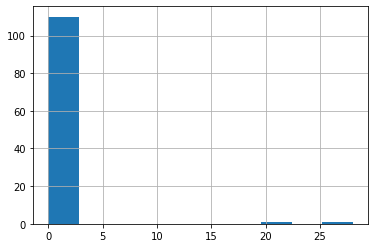

In [14]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count